In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/sample_submission.csv
/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv
/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv


In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer

#rmse function computes rmse between y_true and y_pred
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

df_train = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv')

In [3]:
df_train.head()#Seeing 1st 5 rows of train.csv

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Hospital_Id,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Hospital_Location,Transport_Cost
0,fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,3.62,17.13,No,No,No,Roadways,No,Working Class,No,10/20/17,10/20/17,APO AA 33776,179.50
1,fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,No,Yes,Yes,Roadways,No,Working Class,No,02/22/16,02/24/16,"South Kevin, VT 84493",627732.45
2,fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,No,No,No,Roadways,No,Working Class,No,01/11/18,01/10/18,"Kevinshire, NE 31279",1565.92
3,fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,4.55,17.48,No,No,No,Roadways,No,Working Class,No,08/06/16,08/06/16,DPO AP 61572,257.71
4,fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,Yes,No,No,Roadways,No,Working Class,NaN,12/15/16,12/17/16,"Joshuamouth, AK 01550",8553.52


In [4]:
df_train.shape #Seeing no. of rows and columns in train.csv

(5000, 20)

In [5]:
df_test.shape 

(500, 19)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hospital_Id           5000 non-null   object 
 1   Supplier_Name         5000 non-null   object 
 2   Supplier_Reliability  4413 non-null   float64
 3   Equipment_Height      4717 non-null   float64
 4   Equipment_Width       4557 non-null   float64
 5   Equipment_Weight      4540 non-null   float64
 6   Equipment_Type        4401 non-null   object 
 7   Equipment_Value       5000 non-null   float64
 8   Base_Transport_Fee    5000 non-null   float64
 9   CrossBorder_Shipping  5000 non-null   object 
 10  Urgent_Shipping       5000 non-null   object 
 11  Installation_Service  5000 non-null   object 
 12  Transport_Method      3929 non-null   object 
 13  Fragile_Equipment     5000 non-null   object 
 14  Hospital_Info         5000 non-null   object 
 15  Rural_Hospital       

In [7]:
print(df_train.isnull() .sum()) #Gives total number of null values in each column
df_train.drop_duplicates(inplace=True) 

Hospital_Id                0
Supplier_Name              0
Supplier_Reliability     587
Equipment_Height         283
Equipment_Width          443
Equipment_Weight         460
Equipment_Type           599
Equipment_Value            0
Base_Transport_Fee         0
CrossBorder_Shipping       0
Urgent_Shipping            0
Installation_Service       0
Transport_Method        1071
Fragile_Equipment          0
Hospital_Info              0
Rural_Hospital           586
Order_Placed_Date          0
Delivery_Date              0
Hospital_Location          0
Transport_Cost             0
dtype: int64


In [8]:
nullity_value_percentages_train_df=(df_train.isnull().sum()/df_train.shape[0])*100 
print(nullity_value_percentages_train_df)

Hospital_Id              0.00
Supplier_Name            0.00
Supplier_Reliability    11.74
Equipment_Height         5.66
Equipment_Width          8.86
Equipment_Weight         9.20
Equipment_Type          11.98
Equipment_Value          0.00
Base_Transport_Fee       0.00
CrossBorder_Shipping     0.00
Urgent_Shipping          0.00
Installation_Service     0.00
Transport_Method        21.42
Fragile_Equipment        0.00
Hospital_Info            0.00
Rural_Hospital          11.72
Order_Placed_Date        0.00
Delivery_Date            0.00
Hospital_Location        0.00
Transport_Cost           0.00
dtype: float64


In [9]:
columns_with_null_values = nullity_value_percentages_train_df[nullity_value_percentages_train_df>0]
print(columns_with_null_values) #Columns with finite number of null values

Supplier_Reliability    11.74
Equipment_Height         5.66
Equipment_Width          8.86
Equipment_Weight         9.20
Equipment_Type          11.98
Transport_Method        21.42
Rural_Hospital          11.72
dtype: float64


In [10]:
print(df_train.describe().T)

                       count           mean           std       min      25%  \
Supplier_Reliability  4413.0       0.460925  2.659637e-01       0.0    0.230   
Equipment_Height      4717.0      21.759593  1.194443e+01       3.0   12.000   
Equipment_Width       4557.0       9.585034  5.407542e+00       2.0    6.000   
Equipment_Weight      4540.0  409758.435022  2.808640e+06       3.0  507.000   
Equipment_Value       5000.0    1190.293363  8.724804e+03       3.0    5.260   
Base_Transport_Fee    5000.0      37.374362  2.690791e+01      10.0   16.630   
Transport_Cost        5000.0   17898.060348  2.554261e+05 -588183.2  188.415   

                           50%         75%           max  
Supplier_Reliability     0.450      0.6700  1.000000e+00  
Equipment_Height        20.000     30.0000  7.300000e+01  
Equipment_Width          8.000     12.0000  5.000000e+01  
Equipment_Weight      3137.500  36941.5000  1.179279e+08  
Equipment_Value          7.935     87.0475  3.823857e+05  
Base_

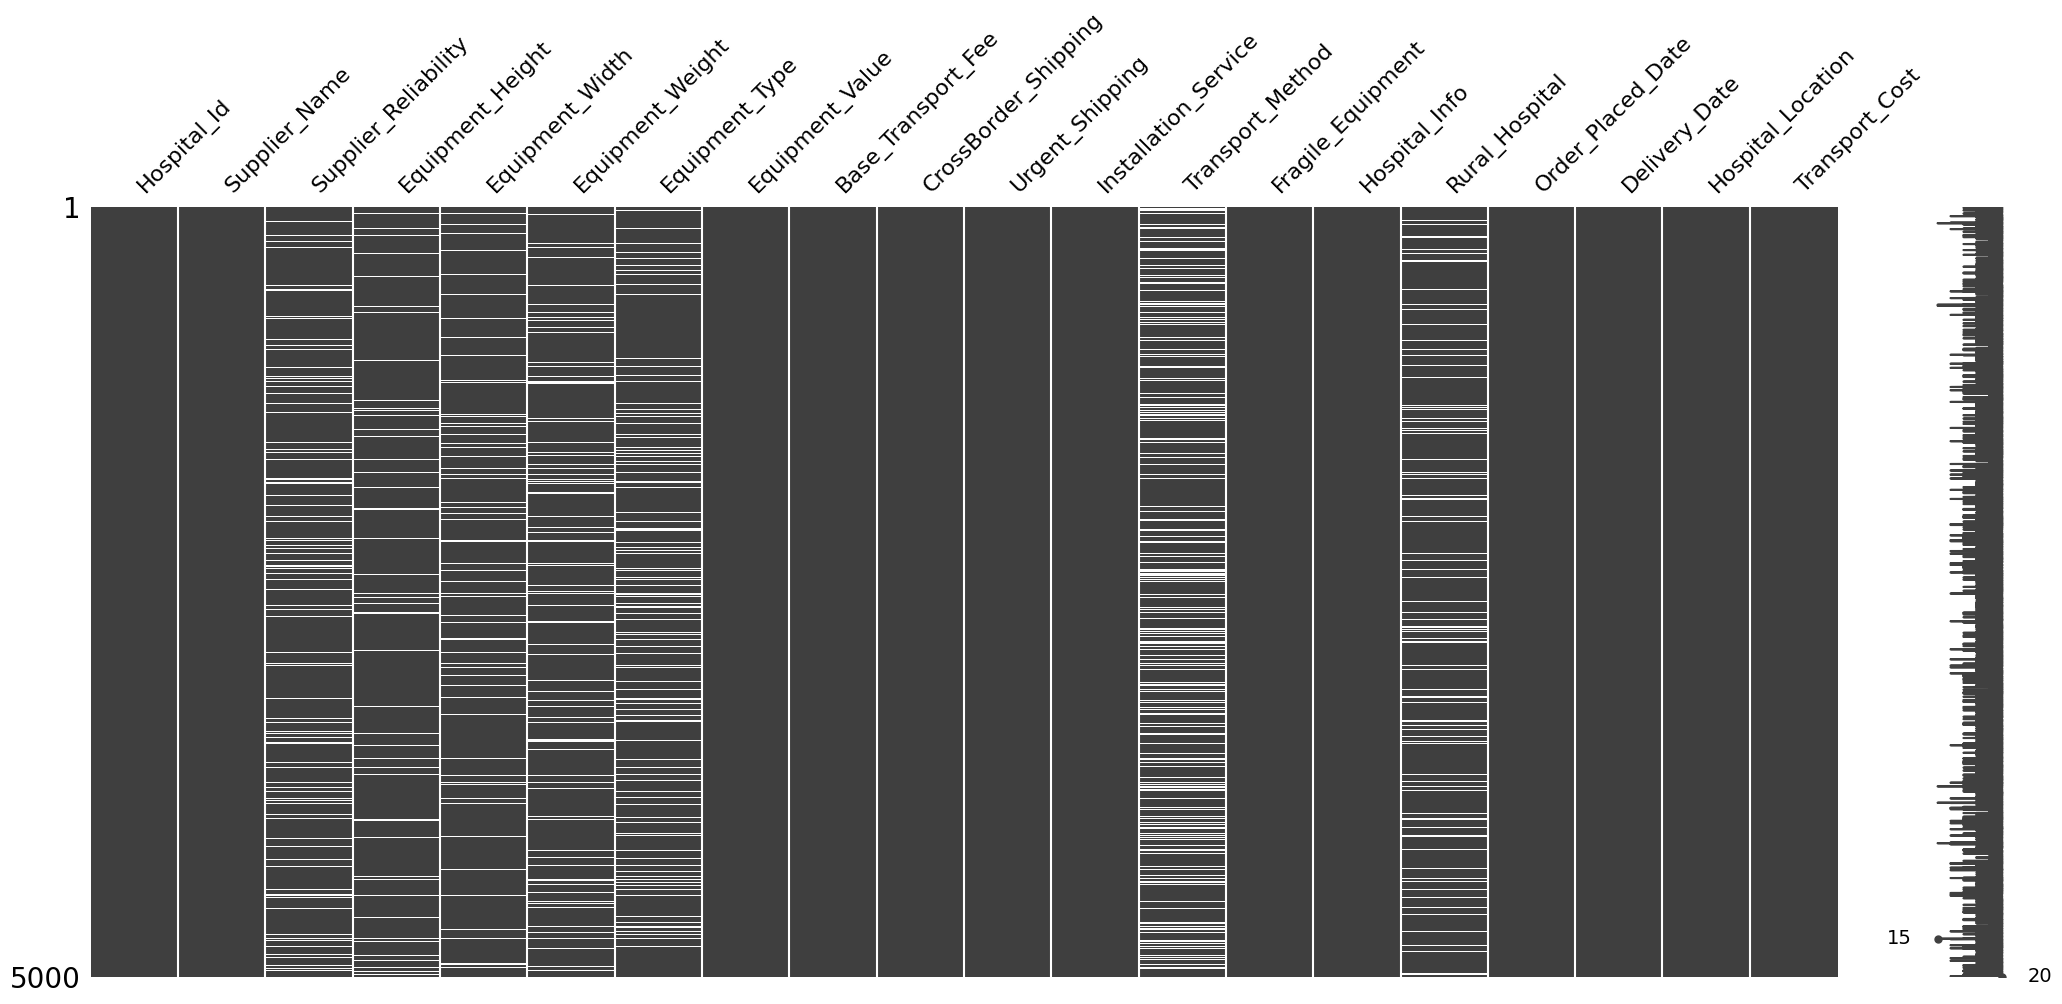

In [11]:
import missingno as msno
msno.matrix(df_train)
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


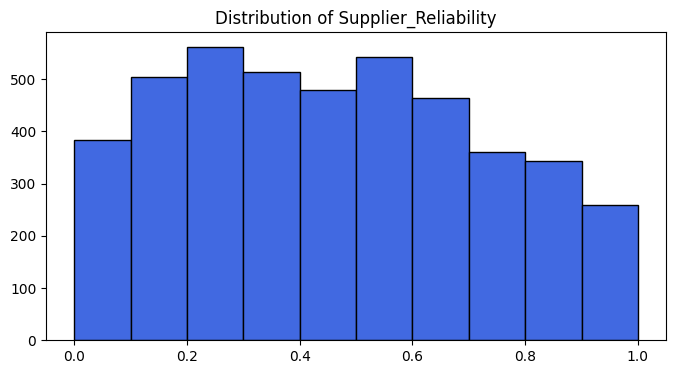

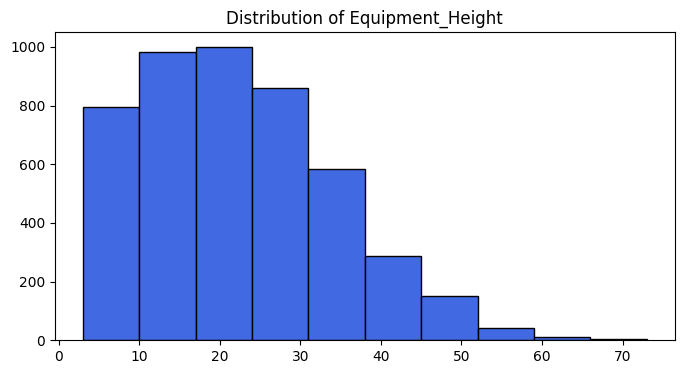

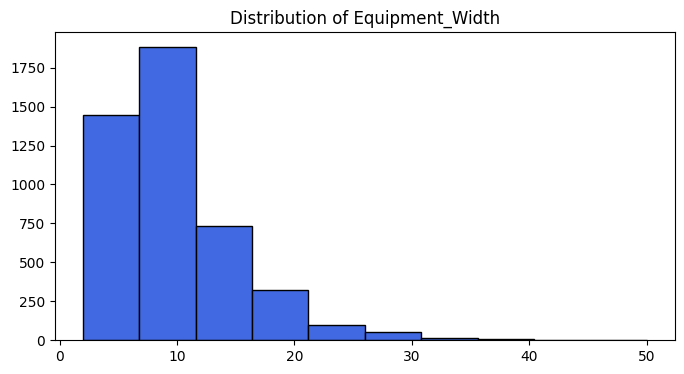

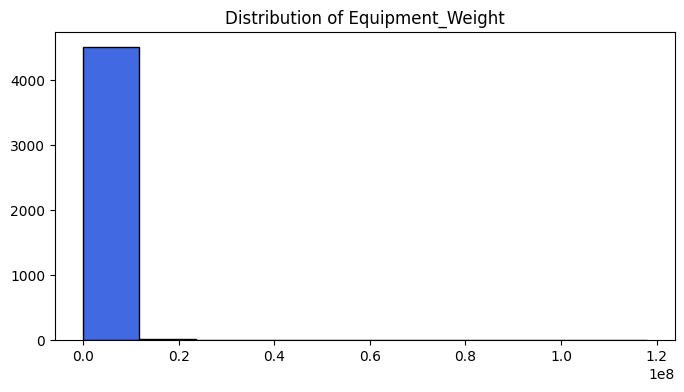

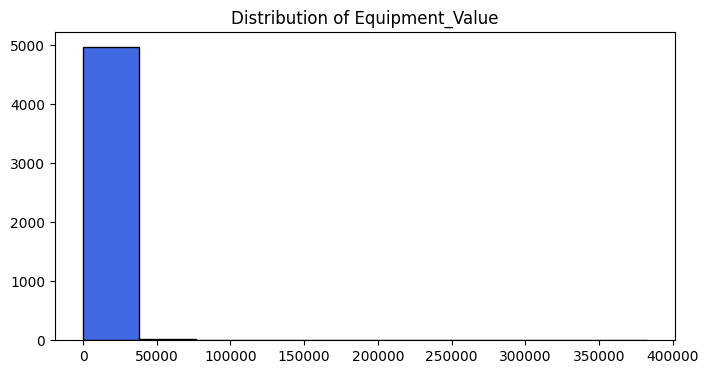

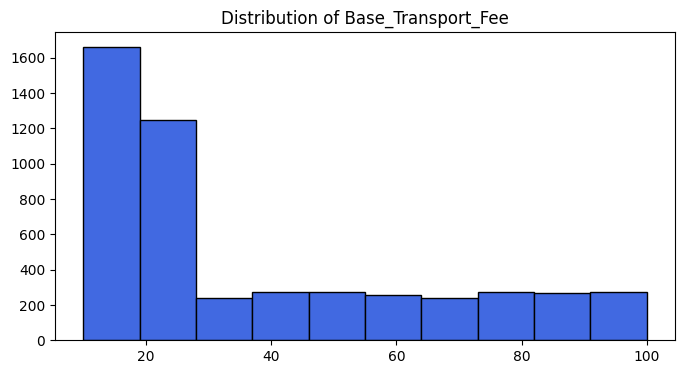

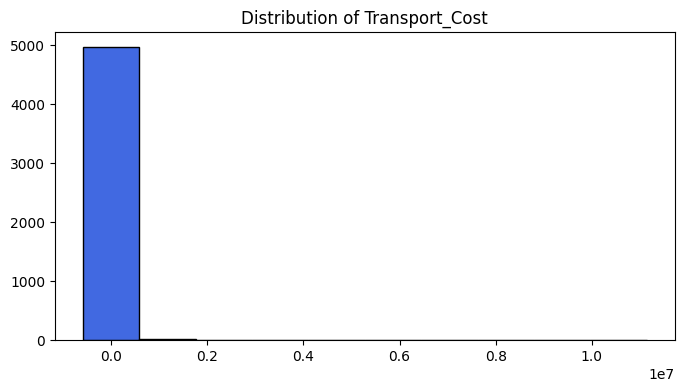

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


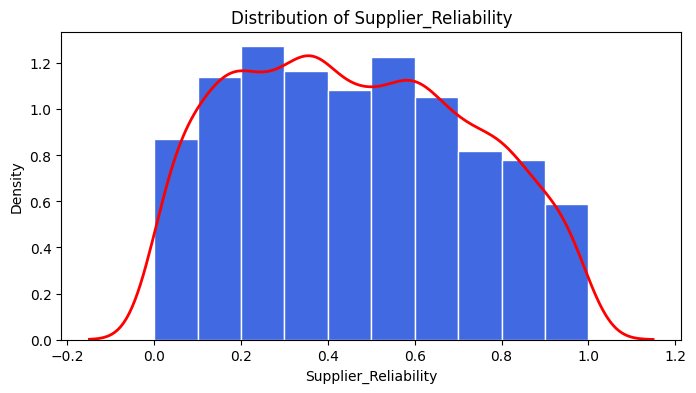

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


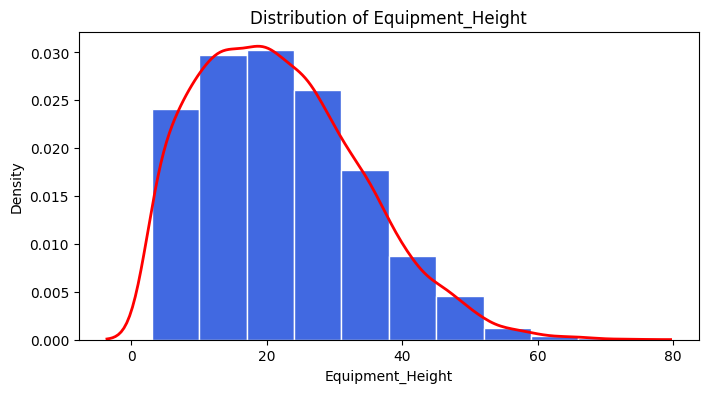

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


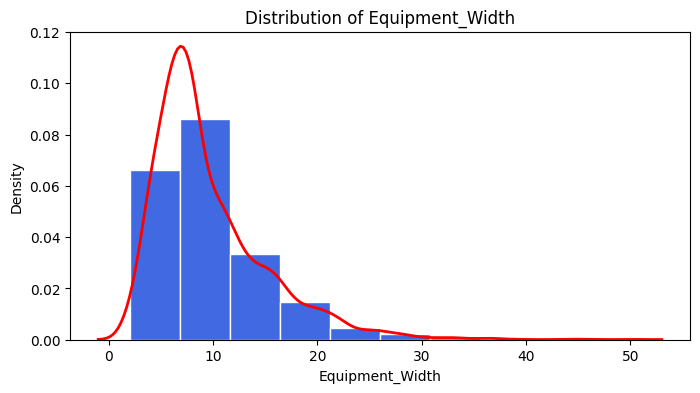

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


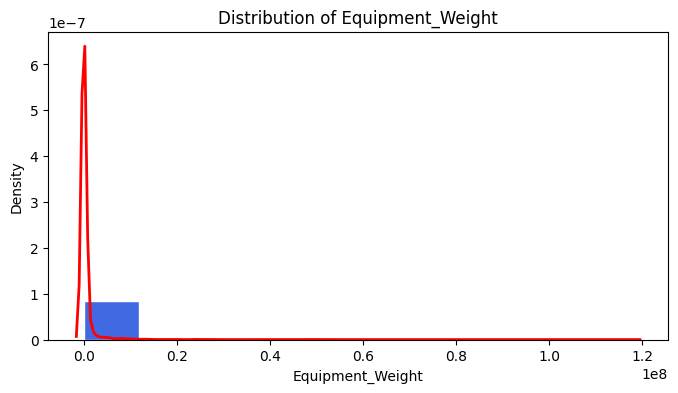

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


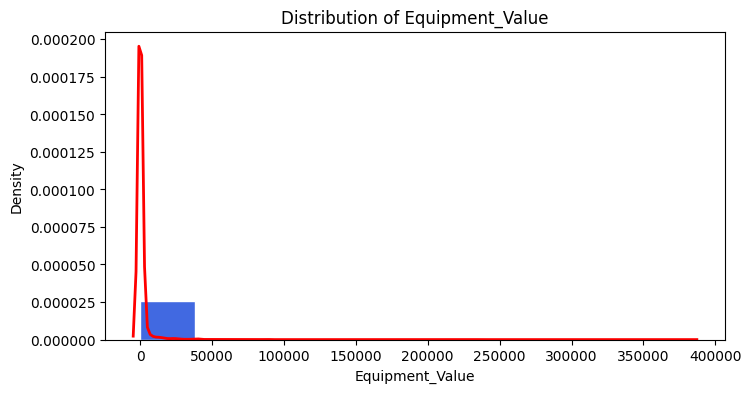

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


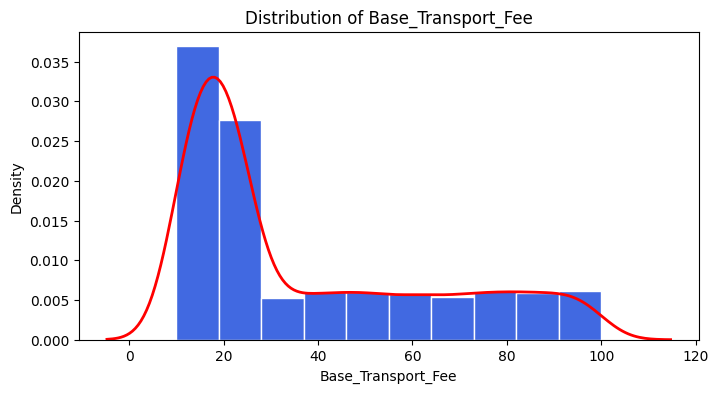

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


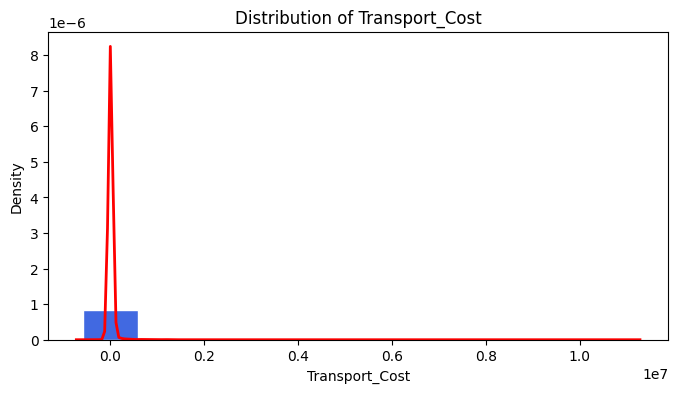

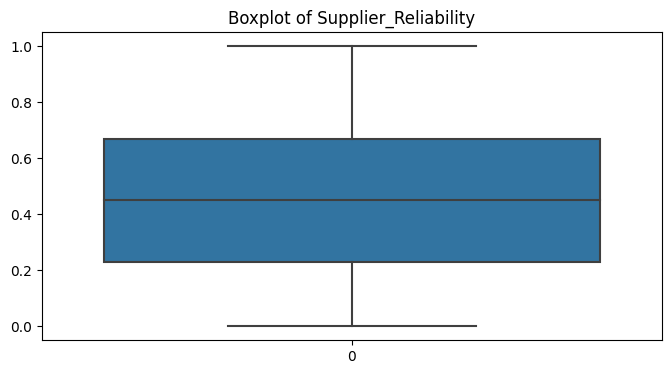

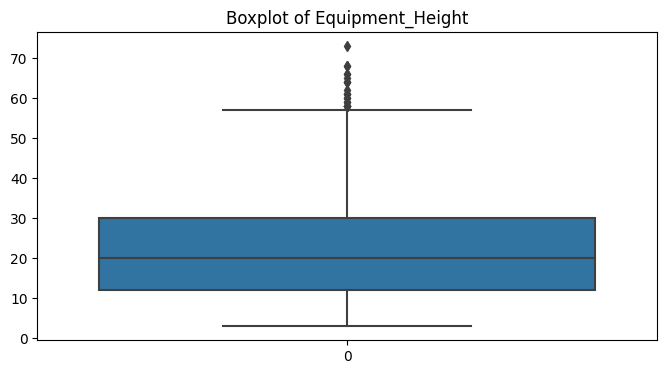

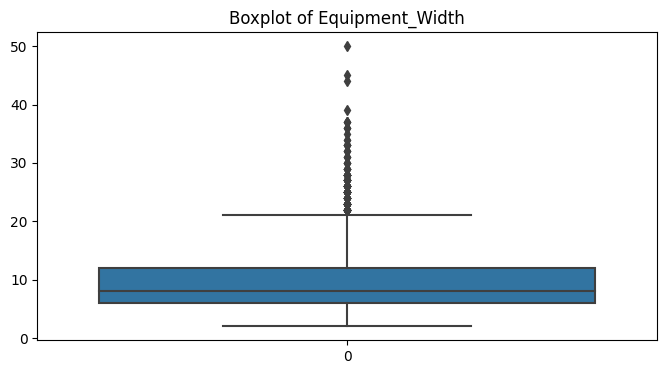

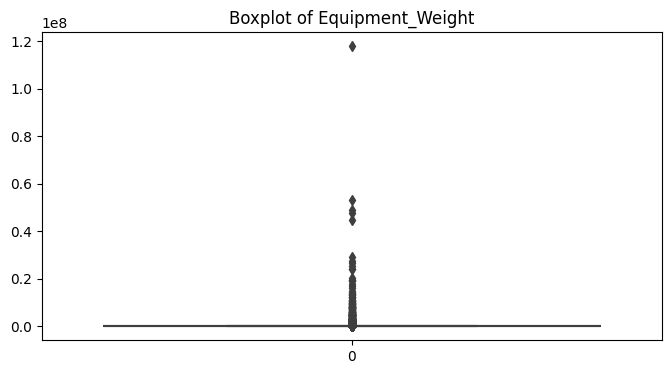

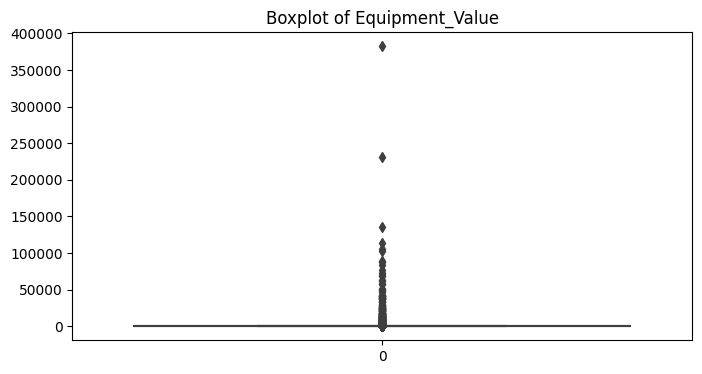

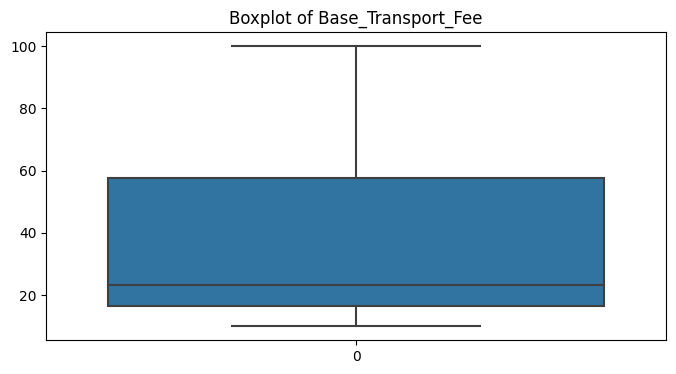

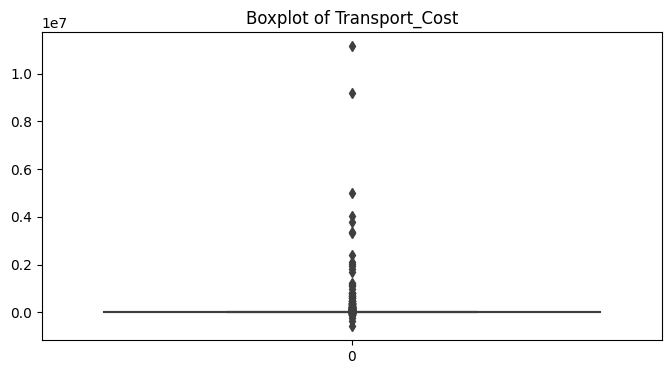

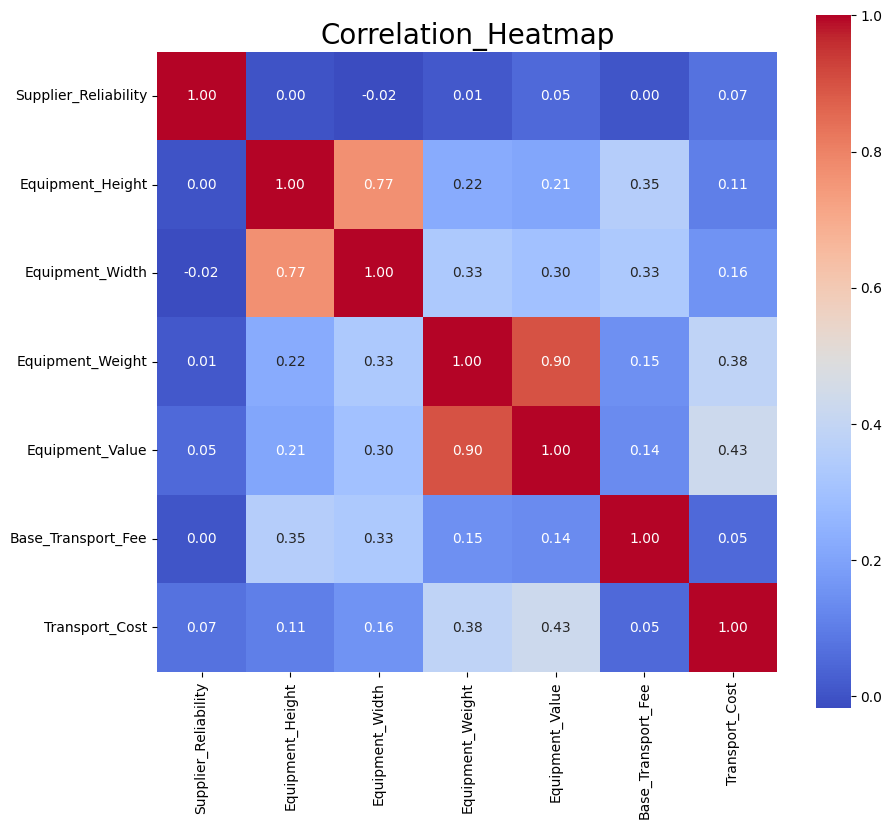

In [12]:
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns #Numerical columns
cat_cols = df_train.select_dtypes(include=['object']).columns
#Plotting distributions of numerical columns
for col in num_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df_train[col], bins=10, color='royalblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.show()
#Plotting distributions and fitting Kernel density estimate which estimates PDF of the data
for col in num_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df_train[col], bins=10, color='royalblue', edgecolor='white',density=True)
    sns.kdeplot(df_train[col], color='red', linewidth=2)
    plt.title(f'Distribution of {col}')
    plt.show()

#Plotting boxplots for outlier detection
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(df_train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
     
#Plotting correlation heatmap 
corr=df_train[num_cols].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation_Heatmap", fontsize=20)
plt.show()

In [13]:
y_train_capped = df_train['Transport_Cost'].clip(lower=0) #Clip all negative costs to zero
y_train = np.log1p(y_train_capped) # Apply log(1+y) transformation to improve normality and reduce skewed data 

df_train = df_train.drop('Transport_Cost', axis=1) #Drop target variable Transport_Cost
hospital_ids = df_test['Hospital_Id']

df_combined = pd.concat([df_train.drop(['Hospital_Id', 'Supplier_Name'], axis=1),
                         df_test.drop(['Hospital_Id', 'Supplier_Name'], axis=1)],
                        ignore_index=True)


date_cols = ['Order_Placed_Date', 'Delivery_Date']
for col in date_cols:
    df_combined[col] = pd.to_datetime(df_combined[col], format='%m/%d/%y', errors='coerce')
    
#Adding new features to dataset and dropping unnecesary features
df_combined['Delivery_Time_Days'] = (df_combined['Delivery_Date'] - df_combined['Order_Placed_Date']).dt.days
df_combined.loc[df_combined['Delivery_Time_Days'] < 0, 'Delivery_Time_Days'] = np.nan


df_combined['Order_Year'] = df_combined['Order_Placed_Date'].dt.year
df_combined['Order_Month'] = df_combined['Order_Placed_Date'].dt.month
df_combined['Order_DayOfWeek'] = df_combined['Order_Placed_Date'].dt.dayofweek
df_combined = df_combined.drop(date_cols, axis=1)


df_combined = df_combined.drop('Hospital_Location', axis=1)


num_cols = ['Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Value']
for col in num_cols:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

df_combined['Equipment_Volume'] = df_combined['Equipment_Height'] * df_combined['Equipment_Width']
df_combined['Density'] = df_combined['Equipment_Weight'] / (df_combined['Equipment_Volume'].replace(0, 1e-6))
df_combined['Value_per_Weight'] = df_combined['Equipment_Value'] / (df_combined['Equipment_Weight'].replace(0, 1e-6))
#Density=mass/Volume, 1e-6  to handle zero Equipment_Volume present in dataset 

# Separate back into train and test sets after adding new features
X_train = df_combined.iloc[:len(y_train)]
X_test = df_combined.iloc[len(y_train):]


#Finding numerical and categorical features
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Define  pipeline  for numerical features : Median Imputation
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define pipeline for categorical features: Impute 'missing', then One-Hot Encoding is done
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

In [14]:
#Fit transform ensures all scaling and imputation is done on X_train
X_train_processed = preprocessor.fit_transform(X_train)

# Check  for any NaN values in training data
if np.any(np.isnan(X_train_processed)):
    print("Missing values found in the processed training data")
    print()
    total_missing = np.sum(np.isnan(X_train_processed))
    print("Total missing values:", total_missing)
else:
    print("No missing values found in the processed training data.")

# Use only transform on the test data 
X_test_processed = preprocessor.transform(X_test)

if np.any(np.isnan(X_test_processed)):
    print("Missing values found in the processed test data\n")
    total_missing = np.sum(np.isnan(X_test_processed))
    print("Total missing values:", total_missing)
else:
    print("No missing values found in the processed test data")

No missing values found in the processed training data.
No missing values found in the processed test data


In [15]:
#  Create PCA + Ridge Regression Pipeline 

pca_ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(random_state=42)),
    ('ridge', Ridge(random_state=42))
])

#  Hyperparameter grid used for tuning hyperparameters
param_grid = {'pca__n_components': [5, 10, 20, 30],'ridge__alpha': [0.1, 1.0, 10.0, 100.0]} # Search for the optimal number of components and the best control parameter
neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#  Grid Search and Optimization 
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pca_ridge_pipeline,
    param_grid=param_grid,
    scoring=neg_mse_scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train) #Fit the PCA+Ridge model with training data and check which hyperparameters are best

best_rmse = np.sqrt(-grid_search.best_score_)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Estimated Cross-Validation RMSE on transformed target: {best_rmse:.4f}")

#  Predict transformed transport cost
y_pred_transformed = grid_search.best_estimator_.predict(X_test)

# Reverse the log transformation and ensure non-negative costs
y_pred_final = np.expm1(y_pred_transformed).clip(min=0)

submission = pd.DataFrame({
    'Hospital_Id': hospital_ids,
    'Transport_Cost': y_pred_final
})

submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'pca__n_components': 30, 'ridge__alpha': 10.0}
Estimated CV(Cross-Validation) RMSE (on transformed target): 2.1214
